# CPEN400D Deep Learning

Instructors: Brad Quinton, Scott Chin

# Assignment 5: Optimization and Regularization

Welcome to the final assignment! 

In this assignment, we will focus on Optimization and Regularization. Specifically, you will extend our custom deep learning framework one more time by implementing the forward and backward propagation through a Batch Normalization and Dropout layer.  We will then explore the corresponding layers, along with L2 regularization, in Keras.

We had originally hoped to develop an assignment involving Recurrent Neural Networks, but due to unforseen events, we have run out of time.  However, at the very end of the assignment, we have listed several tutorials and examples that I have found online that you can look at in your spare time if you want.

This assignment is shorter than the rest.  But do start early because there will be no submission extensions granted - we are not permitted to allow students to submit graded material after the last day of class!

The goal of this assignment is 
- help you better understand the functions of the BatchNormalization and Dropout layers
- introduce you to some important aspects related to optimization and regularization in a real deep learning framework, Keras

Specifically, after this assignment you will have:

- Implemented forward propagation and back propagation in a modular fashion for Batch Normalization and Dropout layer types.
- Train convolutional neural networks with our custom framework using BatchNorm and investigating its impact
- Use Keras to build and train convolutional neural networks that use BatchNorm, Dropout, and L2 regularization and investigate their various effects.


# 0. Completing Your Assignment

Your assignment will be graded based on your implementation and completion of specific code cells within this Jupyter Notebook. The code cells that you need to complete will start with the following text:

**\# GRADED FUNCTION:**

Only these cells will be extracted and graded.  Furthermore, within these code cells will be comments 

**\### START CODE HERE ###** and **\### END CODE HERE ###**

Write your code **between** these comments!  Do **NOT** change any of the code outside of these comments! 

Above these comments, we will also estimate the number of lines of code that you will need to write. We don't check line count, but if you find yourself going significantly beyond these suggestions, you may consider rethinking your approach.

Submit the assignment via JupyterHub like Assignment 2, 3, and 4.

Please also edit the following code cell to include your name and student number.  Thank you!

In [3]:
# Student Name: Alessandro Narciso
# Student Number: 29627156

# 1 Extending Our Deep Learning Framework

The image below shows the class hierarchy of our framework. The new classes (shown in orange) added for which you will implement forward and backward propagation are shown in orange. You do not need your solutions from the previous assignment.  We have provided full implementation for all classes in blue.

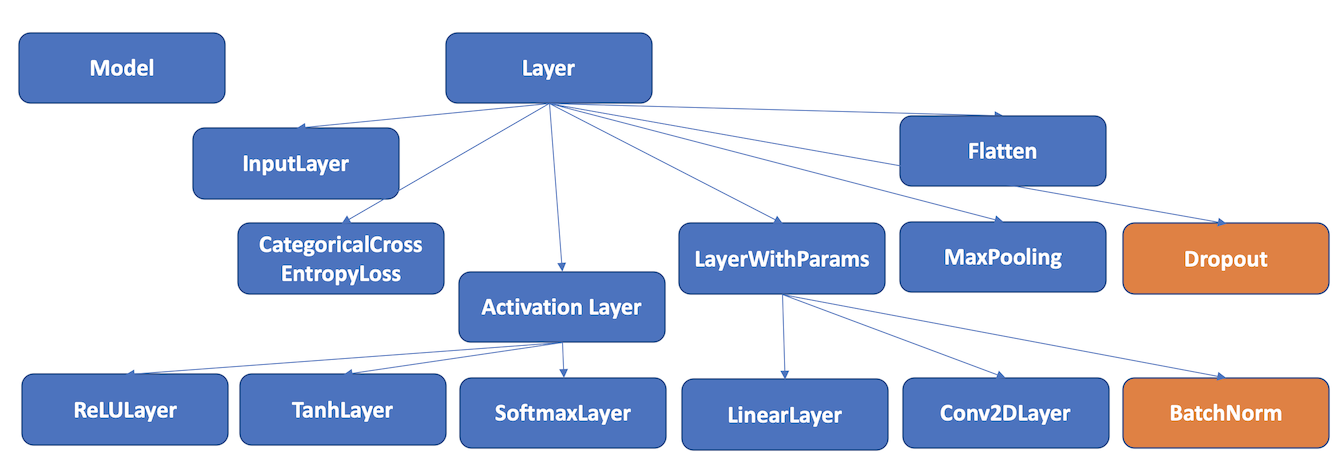

If you need to review what the classes shown in blue do, you can refer to Assignment 3 and 4. As with the previous assignments, the only parts you will need to implement are the forward_propagate() and backward_propagate() of the following classes:
- BatchNorm
- Dropout

You can tackle the above classes in any order that you'd like. 

For each class, you will need to get forward propagate working first before backward propagate. The reason is that backward propagate should depend on some values computed during forward propagate. The framework is structured to cache some values during forward propagate to send to their corresponding backward propagate functions. Furthermore, the built in tests use numerical gradient checking which in turn uses the corresponding forward propgagation function.

The framework has been provided as a collection of Python .py files outside of this notebook.  The functions that you need to implement are set up as static functions inside this Jupyter notebook, and are then inserted into their respective classes. You don't need to understand this process. We just mention it in case you are curious.

## 1.1 Review of the Framework 

Most of this section is a recap of useful information from Assignment 3 and 4.

### 1.1.1 How this will all come together in the end

Recall that in the last assignment we could build arbitrarily deep fully-connected and convolutional neural networks. By the end of this assignment, we will be able to apply optimization (BatchNorm) and regularzation (Dropout) layers. 

Here is an example of how we would specify a CNN architecture using our framework:

    nnmodel = Model([
        InputLayer((28, 28, 1)), # Input (28,28, 3) e.g. 28x28 color image 
        Conv2DLayer(3, (5, 5)),  # Conv K=3 f=5:     z1 = x * w1 + b1
        BatchNorm(),
        ReLULayer(),             # ReLU activation:  a1 = relu(z1) 
        MaxpoolLayer((2, 2)),    # MaxPooling (2,2): z2 = maxpool(a1)
        Conv2DLayer(2, (3, 3)),  # Conv K=2 f=3:     z3 = z2 * w2 + b2
        BatchNorm(),
        ReLULayer(),             # ReLU activation:  a3 = relu(z3)
        FlattenLayer(),          # flatten volume to vector
        LinearLayer(n_c),        # Fully Connected:  z4 = w3 a3 + b4
        SoftmaxLayer()])         # Softmax output:   a4 = softmax(z4)
 
    # Compile model using Categorical Cross Entropy Loss
    nnmodel.compile(loss=CategoricalCrossEntropyLoss())
    
    # Train for 200 gradient descent iterations using learning rate of 0.2
    nnmodel.train(X_train, Y_train, validation_data=(X_validation, Y_validation), epochs=200, learning_rate=0.2)

    # Use the model for prediction on some new data
    nnmodel.predict(X)
    

### 1.1.2 Caching values between forward_propagate() and backward_propagate()

During forward propagation, you may want to cache some values to be used during backward propagation.  We will let you decide which values to cache. The framework is designed so that forward_propagate() functions all initialize and return a cache object.  The cache object will be automatically passed to the corresponding backward propagate function via an input argument. This is all handled for you.  You just need to choose which objects to cache, and write the code to perform the actual caching.  See below for examples.

#### 1.1.2.1 Example of caching one object

For example, to save one numpy array stored in variable named x during linear_forward_propagate():

    def linear_forward_propagate(x, w, b):
        cache = None 

        ### START CODE HERE ###
        ...
        cache = x  # <-- This is what you write. Caching x
        
        ### END CODE HERE ###
        
        return z, cache 
        
The cache object in linear_forward_propagate() will automatically be passed to linear_backward_propagate(). To load load x during linear_backward_propagate():

    def linear_backward_propagate(dJ_dz, cache):
    
        ### START CODE HERE ###        
        ...
        x= cache # <-- This is what you write. Load cached object
        
        ### END CODE HERE ###        
        ...


#### 1.1.2.2 Example of caching more than one object

For example, to save three numpy arrays stored in variable named x,w,b during linear_forward_propagate(), cache the arrays as a single Python tuple

    def linear_forward_propagate(x, w, b):
        cache = None

        ### START CODE HERE ###
        ...
        cache = (x,w,b)  # <-- This is what you write. Caching x,w,b as a single tuple
        
        ### END CODE HERE ###
        
        return z, cache 
        
The cache object in linear_forward_propagate() will automatically be passed to linear_backward_propagate(). To load load x,w,b during linear_backward_propagate(), use Python tuple unpacking:

    def linear_backward_propagate(dJ_dz, cache):
    
        ### START CODE HERE ###        
        ...
        x, w, b = cache # <-- This is what you write. Load cached object and unpack
        
        ### END CODE HERE ###        
        ...

### 1.1.3 Compute Graph

Our framework does not explicitly model a compute graph. Specifically, we do not have separate classes and objects to model compute graph nodes, and connections.  You can think of there being an implicit compute graph described by the operations that you will implement in the forward_propagate() and backward_propagate() methods.  

You should, however, use the idea of a compute graph to help you map out the operations of each layer.  This may help you figure out what operations need to go into each layer's backward_propagate() methods.  



### 1.1.4 Tests

Each function that you will need to implement is followed by one or more test cells. You can run them manually like any other code cell.  Or you can use the "Validate" button on the Jupyter menu which will run all test cells. You can submit your assignment without passing all the tests. But this would mean that you would not get full marks.

**IMPORTANT NOTE**: The Validate button currently gives no user feedback and since some of the tests are slow, it may appear that your notebook is hung.  For now, I recommend running your tests manually.

### 1.1.5 Gradient Checking

The backward propagation tests in this assignment will make use of Gradient Checking (as discussed in lecture) instead of comparing to hardcoded values. In practice, when employing good software development practices such as test-driven development where you write your tests before implementation, it is difficult to write tests that contain the "correct" back-prop values to compare against. The reason is that this is very error prone, and time consuming because you will need to manually compute these values for each backpropagated value that you need.

Whereas with gradient checking, you can write a single generic function to compute an approximation to the numerical gradient of any function, and then simply check that the relative difference of this value is close enough to your backpropagation results.

Gradient checking is a real thing that people use when developing custom low-level backpropagation implementations.

The tests that use gradient checking will always print out error between the numeric gradient for your interest. So don't worry if you see those messages. As long as there are no assertion failures, the test has passed.

Ok let's get started! Run the following code to import NumPy, Matplotlib, and the classes we have provided.

In [31]:
import numpy as np
import matplotlib.pyplot as plt

from batchnorm_layer import BatchNormLayer
from categorical_loss import CategoricalCrossEntropyLoss
from conv_layer import Conv2DLayer
from dropout_layer import DropoutLayer
from input_layer import InputLayer
from flatten_layer import FlattenLayer
from linear_layer import LinearLayer
from maxpool_layer import MaxpoolLayer
from model import Model
from relu_layer import ReLULayer
from softmax_layer import SoftmaxLayer
from tanh_layer import TanhLayer

from a5_tools import rel_error, numeric_gradient

%matplotlib inline


## 1.2 BatchNorm Layer

In this section, you will implement the forward and backward propagate through a Batch Normalization Layer using **vectorized** code (no loops!). You only need to consider the case for when the BatchNorm layer is used with a fully-connected layer. In other words, the input to the layer (for one sample) is a vector and not a volume.

Recall, a BatchNorm layer has inputs $x_i$ and outputs $z_i$, and two sets of learned parameters $\gamma_i$ and $\beta_i$, where $i=1..n$.  For each input, a mean $\mu_i$ and standard deviation $\sigma_i$ is computed.  Each feature is then normalized by subtracting the mean and dividing by standard deviation.  Finally, the output is scaled and shifted by $\gamma_i$ and $\beta_i$, respectively.  

$$ \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

$$ \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

$$ x_i^{'} =\frac{x_i - \mu_i}{\sigma_i}  $$

$$ z_i = \gamma_i x_i^{'} + \beta_i $$


**Hints**
- Draw a compute graph for this layer's operation. Work out the shape of the array on the output of each of your nodes.  This will help you a lot.
- Various numpy functions have a boolean parameter named *keepdims*. You will likely want to set this parameter to True for some of the numpy functions that you will use in your forward and backprop implementation


### 1.2.1 BatchNorm Forward Propagation

Implement the batchnorm_forward_propagate() function below to implement forward propagation through a BatchNorm layer. Use **vectorized** code (no loops!)

**Hints**
- It may be useful to note that the gamma and beta parameters to the function are shape (n, 1) and not (n,). It was easier to implement a solution this way (or I thought so at least)


In [32]:
# GRADED FUNCTION: batchnorm_forward_propagate

@staticmethod
def batchnorm_forward_propagate(x, gamma, beta):
    """ Compute the forward propagation through the batch normalization layer.
        Assume that this layer is only used with fully-connected layers.

    Inputs:
        x: Inputs to this layer. Shape (n, m) where n is number of inputs for 
           one sample (i.e.. number of units of the previous fully-connected 
           layer), and m is number of samples (i.e. mini-batch size).
        gamma: The batchnorm scale parameters in this layer. Shape (n, 1) 
           where n is number of inputs for one sample (i.e.. number of units 
           of the previous fully-connected layer)
        beta: The batchnorm shift parameters in this layer. Shape (n, 1) 
           where n is number of inputs for one sample (i.e.. number of units 
           of the previous fully-connected layer)

    Returns:
        z: Outputs of this layer. Shape (n, m) where n is equal to the number 
           of inputs (for one sample), and m is number of samples (i.e. mini-
           batch size)
        cache: Objects to be sent to backpropagation for this layer.
    """
    
    cache = None

    ### START CODE HERE (~5 lines of code) ###
    # YOUR CODE HERE
    n, m = x.shape #num of inputs, num of samples
    #print(x)
    
    #calculate mean
    mu = 1/m * np.sum(x, axis = 1, keepdims = True)
    #mu = np.mean(x, axis = 1, keepdims = True)
    
    #print(mu)
    #print(mu.shape)
    
    #calculate variance
    var = 1/m * np.sum(((x - mu)**2), axis = 1, keepdims = True)
    #var = np.var(x, axis = 1, keepdims = True)
    
    #print(sigma_sq)
    #print(sigma_sq.shape)
    
    #use normalization equation
    x_prime = (x - mu) / np.sqrt(var)
    
    #print(x_prime)
    #print(x_prime.shape)
    
    #gamme and beta to shift and scale normalized values to make optimization problem easier
    z = x_prime * gamma + beta 
    #print(z)
    #print(z.shape)
    
    cache = x, mu, var, gamma, beta
    ### END CODE HERE ###

    return z, cache


# Set the above function as the forward_propagate() function in the BatchNormLayer class
BatchNormLayer.forward_propagate = batchnorm_forward_propagate

In [33]:
def test_batchnorm_forward():
    # Setup object under test
    n = 4
    m = 2

    l = BatchNormLayer()
    l.compile((n, m))

    # Input Data
    np.random.seed(0)
    x = np.random.randn(n, m)
    gamma = np.random.randn(n,1)
    beta = np.random.randn(n, 1)

    # Forward Propagate
    z, _ = l.forward_propagate(x, gamma, beta)
    z_expected = np.array([[ 0.65781887,  0.86425658],
                           [-0.28892349,  0.53227352],
                           [ 0.5879068 ,  0.29981966],
                           [ 1.78794783, -1.12059918]])

    # Test output
    assert isinstance(z, np.ndarray), 'Expected a Numpy array for z'
    assert z.shape == z_expected.shape, 'Unexpected shape for z. Expected {0} but got {1}'.format(z_expected.shape, z.shape)
    assert np.allclose(z, z_expected), 'Unexpected values for z: \n{0}'.format(z)

    print('PASSED: test_batchnorm_forward()')


# Run the test    
test_batchnorm_forward()

PASSED: test_batchnorm_forward()


### 1.2.3 BatchNorm Backward Propagation

Implement the batchnorm_backward_propagate() function below to compute the backward propagation through a BatchNorm layer. Use **vectorized** code (no loops!).

**Hints**
- This is where drawing out a compute graph and figuring out the output shapes of each node will be very useful.
- Computing the gradients of $\gamma$ and $\beta$ should be very easy. You may want to get those working first.
- Computing the input gradients $\frac{dJ}{dx}$ will likely be the hardest part of this assignment.


In [34]:
# GRADED FUNCTION: batchnorm_backward_propagate

@staticmethod
def batchnorm_backward_propagate(dJ_dz, cache):
    """ Compute the back propagation through this layer. i.e. compute dJ_dx
        to propagate back to the previous layer as well as the parameter
        gradients dJ_dgamma, and dJ_dbeta.

    Inputs:
        dJ_dz: Upstream gradients on the outputs of this layer.
               Shape (n, m) where n is equal to the number of inputs (for 
               one sample), and m is number of samples (i.e. mini-batch size)
        cache: cached values saved during forward propagate

    Returns:
        dJ_dx: Gradients of the inputs to this layer. Shape (n, m).
        dJ_dgamma: Gradients of the scale parameters in this layer. Shape (n, 1).
        dJ_dbeta: Gradients of the shift parameters in this layer. Shape (n, 1).
    """
    ### START CODE HERE (~17 lines of code) ###
    # YOUR CODE HERE
    x, mu, var, gamma, beta = cache
    n, m = x.shape
    
    #gamma and beta gradients ---------------------------
    #gamma * x' + b = z -> upstream gradient * local gradient -> upstream = dJ_dz, locals = x', 1
    dJ_dgamma = np.sum(dJ_dz * (x - mu) / np.sqrt(var), axis = 1, keepdims = True)
    dJ_dbeta = np.sum(dJ_dz * 1, axis = 1, keepdims = True)
    #print(dJ_dgamma)
    #print(dJ_dbeta)
    
    #simplification calculations for gradients -----------------
    xmu = x - mu 
    sqrtvar = np.sqrt(var)
    isvar = 1/sqrtvar
    sq = xmu ** 2
    xhat = xmu * isvar
    
    #derivation of dJ_dx from computational graph -------------------
    
    #backprop from gamma * xhat node
    dxhat = dJ_dz * gamma

    #backprop from xmu * ivar node; inputs: xmu, isvar
    disvar = np.sum(dxhat * xmu, axis = 1, keepdims = True)
    dxmu1 = dxhat * isvar #1 of 2 gradients to subtraction node for x - mu

    #backprop from isvar (inverse of sqrtvar); input: sqrtvar
    #deriv of 1/x = -1/(x^2)
    dsqrtvar = -1/(sqrtvar**2) * disvar

    #backprop from sqrtvar to var; this is a mean node; input: var
    #deriv of x^0.5 = 0.5x^(-0.5)
    dvar = 0.5 * var ** -0.5 * dsqrtvar

    #back prop from var to squaring node; take the derivative of mean 
    dsq = (1/m) * dvar

    #backprop from squaring node; inputs: x - mu; 1 of 2 gradients to subtraction node for x - mu
    #deriv of x^2 = 2x
    dxmu2 = 2 * xmu * dsq

    #backprop from x - mu node; this is just the sum of the 2 xmu gradients; negative for dmu because subtraction
    dx1 = (dxmu1 + dxmu2) #1 of 2 gradients to x node
    dmu = -1 * np.sum(dxmu1 + dxmu2, axis = 1, keepdims = True) #backprop from xmu node to mean node

    #backprop from mean(x) node
    dx2 = (1/m) * dmu #1 of 2 gradients to x node

    #add x node gradients to get total gradient
    dJ_dx = dx1 + dx2
    
    #---------------------
    
    ### END CODE HERE ###

    return dJ_dx, dJ_dgamma, dJ_dbeta


# Set the above function as the backward_propagate() function in the BatchNormLayer class
BatchNormLayer.backward_propagate = batchnorm_backward_propagate

In [35]:
def test_batchnorm_backward():
    # Setup object under test
    n = 4
    m = 3

    l = BatchNormLayer()
    l.compile((n, m))

    # Test that forward propagation works first
    forward_prop_works = True
    try:
        test_batchnorm_forward()
    except:
        forward_prop_works = False
    assert forward_prop_works, """batchnorm_forward_propagate() doesn't seem to work. 
            Make sure you implement forward propagation of this layer before 
            attempting backward propagation. """

    # Input Data
    np.random.seed(0)
    x = np.random.randn(n, m)
    gamma = np.random.randn(n,1)
    beta = np.random.randn(n, 1)
    dJ_dz = np.random.randn(n, m)

    # Forward Propagation
    z, cache = l.forward_propagate(x, gamma, beta)

    # Backward Propagation
    dJ_dx, dJ_dgamma, dJ_dbeta = l.backward_propagate(dJ_dz, cache)

    # Test are numpy arrays
    assert isinstance(dJ_dx, np.ndarray),     'Expected a Numpy array for dJ_dx'
    assert isinstance(dJ_dgamma, np.ndarray), 'Expected a Numpy array for dJ_dgamma'
    assert isinstance(dJ_dbeta, np.ndarray),  'Expected a Numpy array for dJ_dbeta'

    # Test gradient matrix shapes
    assert dJ_dx.shape == x.shape,         "dJ_dx has the wrong shape. Expected {0}, but got {1}".format(x.shape, dJ_dx.shape)
    assert dJ_dgamma.shape == gamma.shape, "dJ_dgamma has the wrong shape. Expected {0}, but got {1}".format(gamma.shape, dJ_dgamma.shape)
    assert dJ_dbeta.shape == beta.shape,   "dJ_dbeta has the wrong shape. Expected {0}, but got {1}".format(beta.shape, dJ_dbeta.shape)

    # Check gradients
    dJ_dx_num = numeric_gradient(lambda x: BatchNormLayer.forward_propagate(x, gamma, beta)[0], x, dJ_dz)
    dJ_dgamma_num = numeric_gradient(lambda gamma: BatchNormLayer.forward_propagate(x, gamma, beta)[0], gamma, dJ_dz)
    dJ_dbeta_num = numeric_gradient(lambda beta: BatchNormLayer.forward_propagate(x, gamma, beta)[0], beta, dJ_dz)

    # Test error between numeric and anlytic gradient
    dJ_dx_error     = rel_error(dJ_dx, dJ_dx_num)
    dJ_dgamma_error = rel_error(dJ_dgamma, dJ_dgamma_num)
    dJ_dbeta_error  = rel_error(dJ_dbeta, dJ_dbeta_num)

    print('Gradient Check Error for dJ_dx: {0}'.format(dJ_dx_error))
    print('Gradient Check Error for dJ_dgamma: {0}'.format(dJ_dgamma_error))
    print('Gradient Check Error for dJ_dbeta: {0}'.format(dJ_dbeta_error))

    assert dJ_dx_error < 1e-8, 'Failed gradient check on dJ_dx'
    assert dJ_dgamma_error < 1e-8, 'Failed gradient check on dJ_dgamma'
    assert dJ_dbeta_error < 1e-8, 'Failed gradient check on dJ_dbeta'

    print('PASSED: test_batchnorm_backward()')
    
# Run the test
test_batchnorm_backward()

PASSED: test_batchnorm_forward()
Gradient Check Error for dJ_dx: 3.7023306239142165e-10
Gradient Check Error for dJ_dgamma: 4.513059270422959e-12
Gradient Check Error for dJ_dbeta: 6.551263480571353e-12
PASSED: test_batchnorm_backward()


## 1.3 Dropout Layer

In this section, you will implement the forward and backward propagate through a Dropout Layer using **vectorized** code (no loops!). You will implement the **Inverted Dropout** version of Dropout (see lecture 19 if this doesn't sound familiar). You only need to consider the case for when this Dropout layer is used with a fully-connected layer. In other words, the input to the layer (for one sample) is a vector and not a volume.


### 1.3.1 Dropout Forward Propagate

Implement the dropout_forward_propagate() function below to compute the forward propagation through a Dropout layer. Use **vectorized** code (no loops!)

**Hints**
- You may want to use the [np.random.uniform()](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.uniform.html) function.


In [36]:
# GRADED FUNCTION: dropout_forward_propagate

@staticmethod
def dropout_forward_propagate(x, keep_prob):
    """ Compute the forward propagation through the dropout layer.
        Assume that this layer is only used with fully-connected layers.

    Inputs:
        x: Inputs to this layer. Shape (n, m) where n is number of inputs for 
           one sample (i.e.. number of units of the previous fully-connected 
           layer), and m is number of samples.
        keep_prob: A single float between 0 and 1 to specify the probability of
           an input not being zeroed out.

    Returns:
        d: Outputs of this layer. Shape (n, m) where n is equal to the number 
           of inputs (for one sample), and m is number of samples
        cache: Objects to be sent to backpropagation for this layer.
    """
    
    cache = None

    ### START CODE HERE (~3 lines of code) ###
    # YOUR CODE HERE
    
    mask = np.random.uniform(low = 0, high = 1.0, size = x.shape)
    #print(mask)
    
    #anything less or equal than keep_prob becomes 1; greater becomes 0
    mask[mask <= keep_prob] = 1
    #print(mask)
    mask[mask != 1] = 0
    
    #print(x)
    #print(mask)
    #print(x.shape)
    #print(mask.shape)
    
    d = (x * mask) / keep_prob
    #print(d)
    
    cache = x, mask, keep_prob
    ### END CODE HERE ###

    return d, cache


# Set the above function as the forward_propagate() function in the Dropout class
DropoutLayer.forward_propagate = dropout_forward_propagate

In [37]:
def test_dropout_forward():
    # Setup object under test
    n = 10
    m = 2
    keep_prob = 0.6

    l = DropoutLayer(keep_prob)
    l.compile((n, m))

    # Input Data
    np.random.seed(1)
    x = np.random.randn(n, m)

    # Forward Propagate
    d, _ = l.forward_propagate(x, keep_prob)
    d_expected = np.array([[ 0.        , -1.01959402],
                           [-0.        , -0.        ],
                           [ 1.44234605, -0.        ],
                           [ 0.        , -0.        ],
                           [ 0.53173183, -0.        ],
                           [ 2.43684656, -3.43356785],
                           [-0.        , -0.64009059],
                           [ 1.88961574, -1.83315211],
                           [-0.28738035, -0.        ],
                           [ 0.07035624,  0.97135869]])

    # Test output
    assert isinstance(d, np.ndarray), 'Expected a Numpy array for d'
    assert d.shape == d_expected.shape, 'Unexpected shape for d. Expected {0} but got {1}'.format(d_expected.shape, d.shape)
    assert np.allclose(d, d_expected), 'Unexpected values for d: \n{0}'.format(d)

    print('PASSED: test_dropout_forward()')


# Run the test
test_dropout_forward()

PASSED: test_dropout_forward()


### 1.3.2 Dropout Backward Propagate

Implement the dropout_backward_propagate() function below to compute the forward propagation through a Dropout layer. Use **vectorized** code (no loops!)

Note: The test cell does not use gradient checking.  Recall that to compute the gradient of one input, two calls to the forward propagation are needed. However, forward propagation of the Dropout layer involves a random process. Without properly controlling this random process, gradient checking will not work.  This isnt' that important for your implementation. Just thought I'd mention it in case you noticed that the test cell does not use Gradient Checking.

In [38]:
# GRADED FUNCTION: dropout_backward_propagate

@staticmethod
def dropout_backward_propagate(dJ_dd, cache):
    """ Compute the back propagation through this layer. i.e. compute dJ_dx

    Inputs:
        dJ_dd: Upstream gradients on the outputs of this layer.
               Shape (n, m) where n is equal to the number of inputs (for 
               one sample), and m is number of samples (i.e. mini-batch size)
        cache: cached values saved during forward propagate

    Returns:
        dJ_dx: Gradients of the inputs to this layer. Shape (n, m).
    """
    
    ### START CODE HERE (2~ lines of code) ###
    # YOUR CODE HERE
    
    #dropout layer has no learnable parameters and doesn't change the volume size of the output
    #simply propagate the gradients through the neurons that were no killed off in fwd pass
    #changing the output of the killed neurons does not change the output; thus their gradient is 0
    
    #dC/dX = dC/dy * dy/dX = dC/dy * D -> dJ_dx = dout * mask
    x, mask, keep_prob = cache
    dJ_dx = (mask * dJ_dd) / keep_prob #upstream gradient * local gradient -> local gradient = mask / keep_prob
    
    ### END CODE HERE ###

    return dJ_dx


# Set the above function as the backward_propagate() function in the Dropout class
DropoutLayer.backward_propagate = dropout_backward_propagate

In [39]:
def test_dropout_backward():
    # Setup object under test
    n = 10
    m = 2
    keep_prob = 0.6

    l = DropoutLayer(keep_prob)
    l.compile((n, m))

    # Test that forward propagation works first
    forward_prop_works = True
    try:
        test_dropout_forward()
    except:
        forward_prop_works = False
    assert forward_prop_works, """dropout_forward_propagate() doesn't seem to work. 
            Make sure you implement forward propagation of this layer before 
            attempting backward propagation. """

    # Input Data
    np.random.seed(1)
    x = np.random.randn(n, m)
    dJ_dd = np.random.randn(n, m)

    # Forward Propagation
    z, cache = l.forward_propagate(x, keep_prob)

    # Backward Propagation
    dJ_dx = l.backward_propagate(dJ_dd, cache)
    dJ_dx_expected = np.array([[-1.8343653 ,  1.90787285],
                               [ 0.        ,  0.83749056],
                               [ 1.50142658, -1.13954643],
                               [-0.        , -1.55961572],
                               [-0.        ,  0.88392578],
                               [-0.        , -0.66125588],
                               [-1.14528783, -0.        ],
                               [-1.11874355, -0.02110766],
                               [-0.        ,  0.39069283],
                               [ 0.        ,  0.        ]])

    assert isinstance(dJ_dx, np.ndarray),     'Expected a Numpy array for dJ_dx'
    assert dJ_dx.shape == x.shape,             "dJ_dx has the wrong shape. Expected {0}, but got {1}".format(x.shape, dJ_dx.shape)
    assert np.allclose(dJ_dx, dJ_dx_expected), 'Unexpected values for dJ_dx: \n{0}'.format(dJ_dx)

    print('PASSED: test_dropout_backward()')
    

# Run the test
test_dropout_backward()

PASSED: test_dropout_forward()
PASSED: test_dropout_backward()


# 2. Training A CNN with BatchNorm Using Our Framework

Now that all the new layers are implemented, we can try them out in our framework!  Well, we will only try out the BatchNorm layer as we didn't have you implement the prediction-time version of the Dropout layer's forward pass.  We will use Dropout in Keras later though!

We will again work with the MNIST dataset of handwritten digits.  

- 28x28 greyscale images
- 60,000 training images and 10,000 validation images
- 10 output classes (one for each digit)

Recall that our framework isn't optimized for speed so we can only train a small subset of the data (we will work with 20 images). The following function, when called, will train up a CNN using the mnist subset data. The function accepts a parameter that let's us choose between two versions of the CNN architecture.  One version uses Batch Normalization, and one does not. For the version with BatchNorm, we only add one BatchNorm layer to the finally fully-connected layer.

Run the following cell to load the function.

In [40]:
from a5_tools import load_mnist, one_hot, plot_sample, plot_costs
from a4_solutions import load_a4_solutions
load_a4_solutions()

def train_mnist_batchnorm(use_batchnorm):
    X_train, Y_train, _, _ = load_mnist()
    
    m = 20
    X_train = X_train[...,:m]
    Y_train = Y_train[...,:m]

    # Specify 10 output classes
    n_c = 10

    # Specify the model
    if use_batchnorm:
        nnmodel = Model([
            InputLayer((28, 28, 1)), # (28,28,1) input volume 
            Conv2DLayer(6, (3,3)),  # Conv layer with 6 (5,5) filters
            ReLULayer(),             # ReLU activation
            Conv2DLayer(4, (3,3)),  # Conv layer with 6 (5,5) filters
            ReLULayer(),    
            FlattenLayer(), 
            LinearLayer(n_c),        # 10 unit fully connected output layer
            BatchNormLayer(),
            SoftmaxLayer()])         # softmax activation
    else:
        nnmodel = Model([
            InputLayer((28, 28, 1)), # (28,28,1) input volume 
            Conv2DLayer(6, (3,3)),  # Conv layer with 6 (5,5) filters
            ReLULayer(),             # ReLU activation
            Conv2DLayer(4, (3,3)),  # Conv layer with 6 (5,5) filters
            ReLULayer(),    
            FlattenLayer(), 
            LinearLayer(n_c),        # 10 unit fully connected output layer
            SoftmaxLayer()])         # softmax activation

        
    # Use Categorical Cross Entropy and compile compute graph
    nnmodel.compile(loss=CategoricalCrossEntropyLoss())

    # Train using Mini Batch Gradient Descent
    costs_train = nnmodel.train_sgd(X_train, 
                                    one_hot(Y_train, n_c),
                                    validation_data=None,
                                    epochs=10,          # Training Epochs
                                    learning_rate=0.05, # Learning Rate
                                    batch_size=128,     # Mini-Batch Gradient Descent batch size
                                    print_freq=1)       # Number of iterations between printing progress

    predictions, _ = nnmodel.predict(X_train)
    plot_costs(costs_train)

    print('Class Predictions')
    print(predictions)
    print('True Labels')
    print(Y_train)
    

Run the following cell to perform training on the model without BatchNorm layers. You will see very slow progress. We only train for 10 epochs, but this is enough to see a difference when you run the version that does use BatchNorm layers.  

Run the following cell now.

X (training)   shape: (28, 28, 1, 60000)
Y (training)   shape: (60000,)
X (validation) shape: (28, 28, 1, 10000)
Y (validation) shape: (10000,)

0 loss: 2.30226144 - accuracy: 0.100
1 loss: 2.30088330 - accuracy: 0.100
2 loss: 2.29958178 - accuracy: 0.200
3 loss: 2.29832316 - accuracy: 0.200
4 loss: 2.29713633 - accuracy: 0.200
5 loss: 2.29592077 - accuracy: 0.200
6 loss: 2.29466958 - accuracy: 0.200
7 loss: 2.29334122 - accuracy: 0.200
8 loss: 2.29189679 - accuracy: 0.200
9 loss: 2.29029541 - accuracy: 0.200


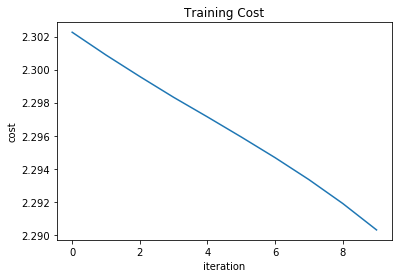

Class Predictions
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True Labels
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [21]:
train_mnist_batchnorm(False)

Now run the following cell which will train the CNN model that employs BatchNorm.

X (training)   shape: (28, 28, 1, 60000)
Y (training)   shape: (60000,)
X (validation) shape: (28, 28, 1, 10000)
Y (validation) shape: (10000,)

0 loss: 2.04233789 - accuracy: 0.200
1 loss: 0.70733382 - accuracy: 0.950
2 loss: 0.62032882 - accuracy: 0.950
3 loss: 0.56089311 - accuracy: 1.000
4 loss: 0.51589908 - accuracy: 1.000
5 loss: 0.47956866 - accuracy: 1.000
6 loss: 0.44987053 - accuracy: 1.000
7 loss: 0.42689634 - accuracy: 1.000
8 loss: 0.41713288 - accuracy: 1.000
9 loss: 0.43044551 - accuracy: 1.000


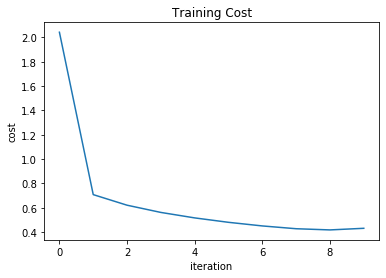

Class Predictions
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
True Labels
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [22]:
train_mnist_batchnorm(True)

You should see that this version achieves 100% accuracy (albet on a tiny training set) in 3 epochs!

To be more realistic, let's now move to using Keras and train models that use full training sets.

# 3. Batch Normalization in Keras 

We will now try out Batch Normalization in Keras.  We will use another toy data set called [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist).  Fashion MNIST was created to replace MNIST.  The motivation for this is that MNIST is just too easy and doens't really represent a real machine learning or deep learning classification problem.  One way to think of it is that all MNIST images are composed of simple lines.  There really isn't much variety in the low-level features. 

Fashion MNIST shares a lot of properties as MNIST
- Same number of samples: 60000 training and 10000 validation images
- 28x28 grayscale images. Images are 2D drawings of clothing
- 10 classes 
  - T-shirt/top
  - Trouser
  - Pullover
  - Dress
  - Coat
  - Sandal
  - Shirt
  - Sneaker
  - Bag
  - Ankle boot

Here are some examples from the data set:

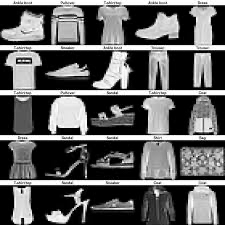

Like before, we will train up a model with and without BatchNorm layers. Specifically, we use Lenet5 CNN architecture. In the version with BatchNorm layers, we add a BatchNorm layer after each convolutional and fully-connected layer.  Have a look at the following function to see where we put the BatchNorm layers.

As an aside, you may notice that we use the Adam optimizer here on out instead of plain Mini-Batch Gradient Descent. You can choose your optimizer by supplying a string with the name of the optimizer as we've done below. Doing it this way simply uses default hyperparameter values (for Adam, these would be the two beta terms for the exponentially weighted moving average decay factors). To change the default optimizer hyperparameters, you would need to instantiate the corresponding optimizer object (as we did in the last assignment).  Feel free to try out different optimizers later to see what happens.

Run the following cell to load the function into memory.

In [23]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.initializers import RandomNormal, he_normal
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

from a5_tools import one_hot, plot_sample, plot_costs, plot_decision_boundary, load_data, plot_training_history, load_fashion_mnist

def keras_batchnorm_example(use_batchnorm):
    X_train, Y_train, X_valid, Y_valid = load_fashion_mnist()

    n_c = 10
    
    if use_batchnorm:
        model = Sequential([
            Input((28,28,1)),
            Conv2D(filters=6, kernel_size=(5, 5)),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),
            Conv2D(filters=16, kernel_size=(5, 5)),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),
            Flatten(),
            Dense(120),
            BatchNormalization(),
            Activation('relu'),
            Dense(84),
            BatchNormalization(),
            Activation('relu'),
            Dense(10),
            Activation('softmax'),
        ])
    else:
        model = Sequential([
            Input((28,28,1)),
            Conv2D(filters=6, kernel_size=(5, 5)),
            Activation('relu'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),
            Conv2D(filters=16, kernel_size=(5, 5)),
            Activation('relu'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),
            Flatten(),
            Dense(120),
            Activation('relu'),
            Dense(84),
            Activation('relu'),
            Dense(10),
            Activation('softmax'),
        ])
        
    # Compile the model to use categorial cross entropy loss, 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, 
                        one_hot(Y_train, n_c).T, 
                        validation_data=(X_valid, one_hot(Y_valid, n_c).T), 
                        epochs=10, 
                        batch_size=128)


    plot_training_history(history)

Run the following cell to train the CNN without BatchNorm.

4423680/4422102 [==============================] - 0s 0us/step
X (training)   shape: (60000, 28, 28, 1)
Y (training)   shape: (60000,)
X (validation) shape: (10000, 28, 28, 1)
Y (validation) shape: (10000,)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 40s 663us/sample - loss: 0.6823 - accuracy: 0.7535 - val_loss: 0.4937 - val_accuracy: 0.8224
Epoch 2/10
60000/60000 [==============================] - 38s 638us/sample - loss: 0.4376 - accuracy: 0.8432 - val_loss: 0.4285 - val_accuracy: 0.8495
Epoch 3/10
60000/60000 [==============================] - 39s 657us/sample - loss: 0.3832 - accuracy: 0.8615 - val_loss: 0.3865 - val_accuracy: 0.8655
Epoch 4/10
60000/60000 [==============================] - 39s 653us/sample - loss: 0.3517 - accuracy: 0.8722 - val_loss: 0.3820 - val_accuracy: 0.8642
Epoch 5/10
60000/60000 [==============================] - 39s 645us/sample - loss: 0.3311 - accuracy: 0.8794 - val_loss: 0.3551 - val_accu

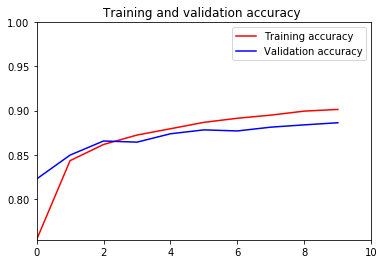

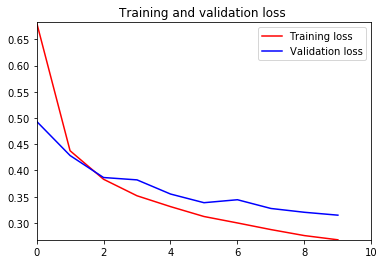

<Figure size 432x288 with 0 Axes>

In [ ]:
# Train model without Batch Norm
keras_batchnorm_example(False)

Now run the following cell to train the CNN that does use BatchNorm.  We will discuss the results afterwards.

X (training)   shape: (60000, 28, 28, 1)
Y (training)   shape: (60000,)
X (validation) shape: (10000, 28, 28, 1)
Y (validation) shape: (10000,)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 58s 972us/sample - loss: 0.4926 - accuracy: 0.8270 - val_loss: 0.4125 - val_accuracy: 0.8448
Epoch 2/10
60000/60000 [==============================] - 56s 933us/sample - loss: 0.3232 - accuracy: 0.8828 - val_loss: 0.3526 - val_accuracy: 0.8717
Epoch 3/10
60000/60000 [==============================] - 55s 918us/sample - loss: 0.2858 - accuracy: 0.8946 - val_loss: 0.3386 - val_accuracy: 0.8772
Epoch 4/10
60000/60000 [==============================] - 55s 918us/sample - loss: 0.2584 - accuracy: 0.9044 - val_loss: 0.3309 - val_accuracy: 0.8765
Epoch 5/10
60000/60000 [==============================] - 57s 948us/sample - loss: 0.2399 - accuracy: 0.9126 - val_loss: 0.3191 - val_accuracy: 0.8828
Epoch 6/10
60000/60000 [==========================

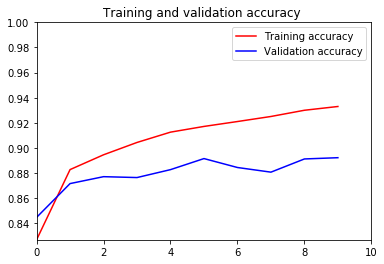

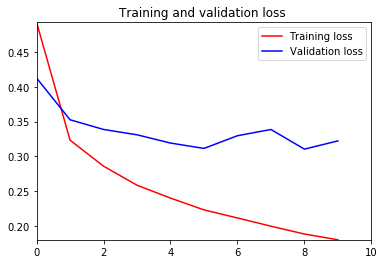

<Figure size 432x288 with 0 Axes>

In [25]:
# Train model with BatchNorm
keras_batchnorm_example(True)

What you should see is that within 10 epochs, the BatchNorm version achieves a training accuracy of 93.4% whereas the model without BatchNorm only achieves 90.1%.  Similarly for validation accuracy, the BatchNorm and no BatchNorm models achieve 89.1% and 88.7%, respectively.

Another way to look at it is that with BatchNorm, the model can achieve 90.1% training accuracy (the final training accuracy of the No-BatchNorm version) by epoch 4 instead of 10.

Now it is clear from the curves that we should let training run for longer. But the takeaway is that for many tasks (especially in Computer Vision), BatchNorm layers can help significantly speed up the training process.

# 4. Regularization in Keras 

Let's have a closer look at Regularization in Keras now.  Specifically, we will look at Dropout and L2 regularization.

For this section, we will work with some simple toy data so that we can easily plot.  The data has two input features, and two class labels (red and blue).  The data is already normalized.  Run the following cell to see this data plotted.

What you should see is data that looks roughly linearly-separable, except there is a lot of noise along the boundary.

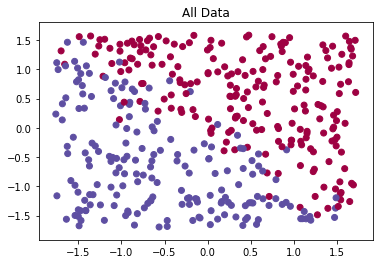

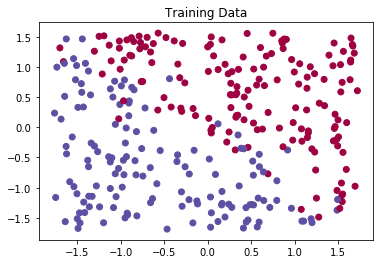

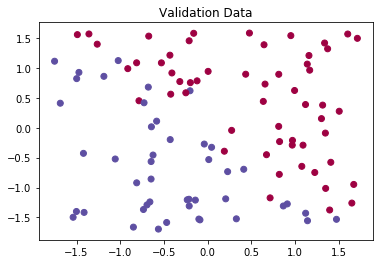

In [26]:
def plot_regularization_data():
    X_train, Y_train, X_valid, Y_valid = load_data()

    # Plot Data
    plt.scatter(X_train[0, :], X_train[1, :], c=Y_train, cmap=plt.cm.Spectral)
    plt.scatter(X_valid[0, :], X_valid[1, :], c=Y_valid, cmap=plt.cm.Spectral)
    plt.title('All Data')
    plt.show()
    
    plt.scatter(X_train[0, :], X_train[1, :], c=Y_train, cmap=plt.cm.Spectral)
    plt.title('Training Data')
    plt.show()
    
    plt.scatter(X_valid[0, :], X_valid[1, :], c=Y_valid, cmap=plt.cm.Spectral)
    plt.title('Validation Data')
    plt.show()
    
plot_regularization_data()

We will work with a simple fully-connected neural network with 3 hidden-layers consisting of 300, 200, and 100 units. Each layer uses ReLU activation and the output is a 2-output softmax output.

The following function let's us train three different versions of the model
- No regularization
- Dropout regularization after each hidden layer with a keep_prob=0.3
- L2 regularization with $\lambda=0.01$

Run the following cell to load the function.

In [27]:
def keras_dropout_example(use_dropout, use_l2):
    X_train, Y_train, X_valid, Y_valid = load_data()

    n_c = 2
    
    if use_dropout:
        if use_l2:
            model = Sequential([
                Input((2,)),
                Dense(300, kernel_regularizer=regularizers.l2(0.01)),
                Activation('relu'),
                Dropout(0.7),
                Dense(200, kernel_regularizer=regularizers.l2(0.01)),
                Activation('relu'),
                Dropout(0.7),
                Dense(100, kernel_regularizer=regularizers.l2(0.01)),
                Activation('relu'),
                Dropout(0.7),
                Dense(n_c),
                Activation('softmax'),
            ])
        else:
            model = Sequential([
                Input((2,)),
                Dense(300),
                Activation('relu'),
                Dropout(0.7),
                Dense(200),
                Activation('relu'),
                Dropout(0.7),
                Dense(100),
                Activation('relu'),
                Dropout(0.7),
                Dense(n_c),
                Activation('softmax'),
            ])
    else:
        if use_l2:
            model = Sequential([
                Input((2,)),
                Dense(300, kernel_regularizer=regularizers.l2(0.01)),
                Activation('relu'),
                Dense(200, kernel_regularizer=regularizers.l2(0.01)),
                Activation('relu'),
                Dense(100, kernel_regularizer=regularizers.l2(0.01)),
                Activation('relu'),
                Dense(n_c),
                Activation('softmax'),
            ])
        else:
            model = Sequential([
                Input((2,)),
                Dense(300),
                Activation('relu'),
                Dense(200),
                Activation('relu'),
                Dense(100),
                Activation('relu'),
                Dense(n_c),
                Activation('softmax'),
            ])
        
    # Compile the model to use categorial cross entropy loss, 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train.T, 
                        one_hot(Y_train, n_c).T, 
                        validation_data=(X_valid.T, one_hot(Y_valid, n_c).T), 
                        epochs=500, 
                        batch_size=512,
                        verbose=2)


    plot_training_history(history)
    plot_decision_boundary(X_train, Y_train, lambda x: model.predict_classes(x.T))
        


Now run the following three training cells, and we will discuss the results aftwerwards.

Train on 300 samples, validate on 100 samples
Epoch 1/500
300/300 - 1s - loss: 0.7019 - accuracy: 0.3300 - val_loss: 0.6483 - val_accuracy: 0.8900
Epoch 2/500
300/300 - 0s - loss: 0.6477 - accuracy: 0.8967 - val_loss: 0.6070 - val_accuracy: 0.9100
Epoch 3/500
300/300 - 0s - loss: 0.6045 - accuracy: 0.9033 - val_loss: 0.5695 - val_accuracy: 0.9100
Epoch 4/500
300/300 - 0s - loss: 0.5651 - accuracy: 0.9067 - val_loss: 0.5327 - val_accuracy: 0.9200
Epoch 5/500
300/300 - 0s - loss: 0.5268 - accuracy: 0.9133 - val_loss: 0.4971 - val_accuracy: 0.9200
Epoch 6/500
300/300 - 0s - loss: 0.4898 - accuracy: 0.9200 - val_loss: 0.4618 - val_accuracy: 0.9200
Epoch 7/500
300/300 - 0s - loss: 0.4532 - accuracy: 0.9167 - val_loss: 0.4269 - val_accuracy: 0.9200
Epoch 8/500
300/300 - 0s - loss: 0.4171 - accuracy: 0.9200 - val_loss: 0.3929 - val_accuracy: 0.9200
Epoch 9/500
300/300 - 0s - loss: 0.3819 - accuracy: 0.9200 - val_loss: 0.3604 - val_accuracy: 0.9200
Epoch 10/500
300/300 - 0s - loss: 0.3484 - ac

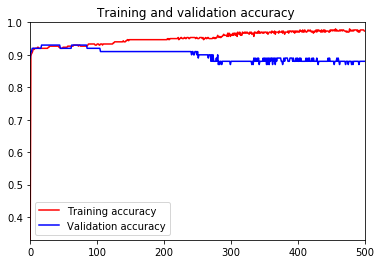

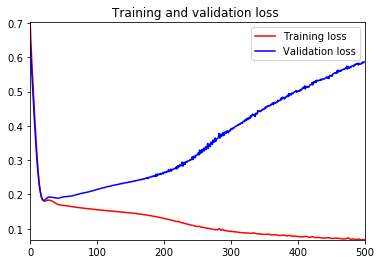

<Figure size 432x288 with 0 Axes>

(525, 549) (525, 549)


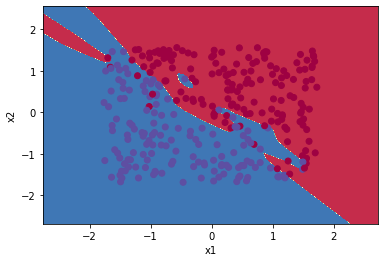

In [28]:
# No regularization
keras_dropout_example(False, False)

Train on 300 samples, validate on 100 samples
Epoch 1/500
300/300 - 1s - loss: 4.4661 - accuracy: 0.7167 - val_loss: 4.3437 - val_accuracy: 0.9100
Epoch 2/500
300/300 - 0s - loss: 4.3412 - accuracy: 0.9000 - val_loss: 4.2291 - val_accuracy: 0.9200
Epoch 3/500
300/300 - 0s - loss: 4.2252 - accuracy: 0.9167 - val_loss: 4.1221 - val_accuracy: 0.9200
Epoch 4/500
300/300 - 0s - loss: 4.1165 - accuracy: 0.9167 - val_loss: 4.0189 - val_accuracy: 0.9200
Epoch 5/500
300/300 - 0s - loss: 4.0115 - accuracy: 0.9100 - val_loss: 3.9182 - val_accuracy: 0.9200
Epoch 6/500
300/300 - 0s - loss: 3.9091 - accuracy: 0.9167 - val_loss: 3.8194 - val_accuracy: 0.9200
Epoch 7/500
300/300 - 0s - loss: 3.8087 - accuracy: 0.9167 - val_loss: 3.7228 - val_accuracy: 0.9200
Epoch 8/500
300/300 - 0s - loss: 3.7102 - accuracy: 0.9200 - val_loss: 3.6279 - val_accuracy: 0.9200
Epoch 9/500
300/300 - 0s - loss: 3.6138 - accuracy: 0.9200 - val_loss: 3.5351 - val_accuracy: 0.9200
Epoch 10/500
300/300 - 0s - loss: 3.5196 - ac

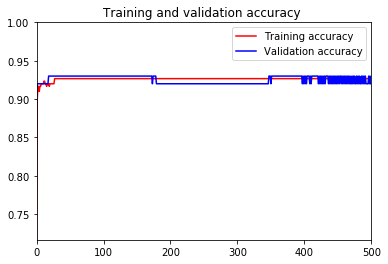

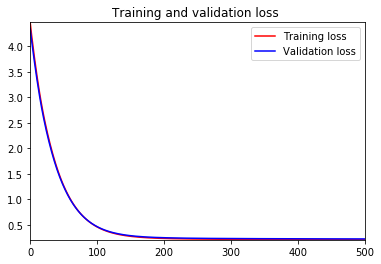

<Figure size 432x288 with 0 Axes>

(525, 549) (525, 549)


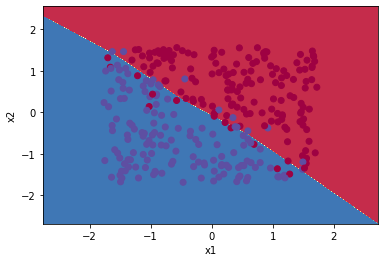

In [29]:
# L2 Regularization
keras_dropout_example(False, True)

Train on 300 samples, validate on 100 samples
Epoch 1/500
300/300 - 1s - loss: 0.7177 - accuracy: 0.5067 - val_loss: 0.6653 - val_accuracy: 0.8800
Epoch 2/500
300/300 - 0s - loss: 0.6953 - accuracy: 0.5667 - val_loss: 0.6466 - val_accuracy: 0.8800
Epoch 3/500
300/300 - 0s - loss: 0.6763 - accuracy: 0.5633 - val_loss: 0.6291 - val_accuracy: 0.9100
Epoch 4/500
300/300 - 0s - loss: 0.6486 - accuracy: 0.6467 - val_loss: 0.6118 - val_accuracy: 0.9100
Epoch 5/500
300/300 - 0s - loss: 0.6609 - accuracy: 0.6400 - val_loss: 0.5944 - val_accuracy: 0.9200
Epoch 6/500
300/300 - 0s - loss: 0.6325 - accuracy: 0.6633 - val_loss: 0.5765 - val_accuracy: 0.9200
Epoch 7/500
300/300 - 0s - loss: 0.6049 - accuracy: 0.7333 - val_loss: 0.5580 - val_accuracy: 0.9200
Epoch 8/500
300/300 - 0s - loss: 0.6018 - accuracy: 0.7000 - val_loss: 0.5388 - val_accuracy: 0.9200
Epoch 9/500
300/300 - 0s - loss: 0.5705 - accuracy: 0.7367 - val_loss: 0.5189 - val_accuracy: 0.9200
Epoch 10/500
300/300 - 0s - loss: 0.5597 - ac

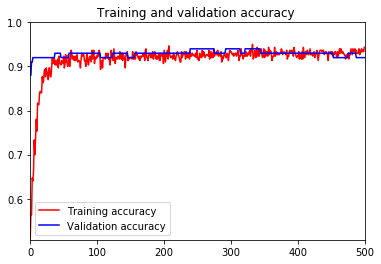

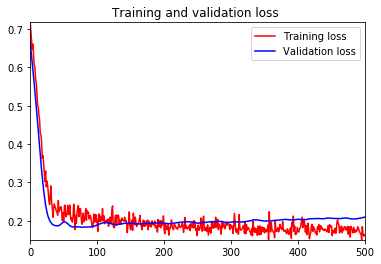

<Figure size 432x288 with 0 Axes>

(525, 549) (525, 549)


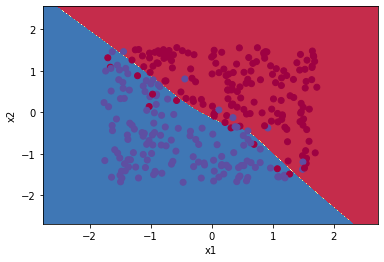

In [30]:
# Dropout Regularization
keras_dropout_example(True, False)

In all cases, the model has a large capacity to learn the decision boundary to separate the two classes.  Without regularization, the optimizer will try to make the most of this capacity on the training data. 

In the training run without any regularization, you will see a decision boundary that exhibits extreme overfitting. If you also inspect the loss and accuracy curves, you will also see the hallmark shape of validation quality improving to a point, then as the optimizer works harder and harder to fit the training data, the improved training fit no longer generalizes well and validation loss and accuracy start to get worse and worse.

Both L2 and Dropout regularziation leads to a much smoother decision boundary - one that looks like it should generalize better to new data. Looking at the loss and accuracy curves, we also no longer see the overfit shape. 

In real problems, it is not uncommon to use both L2 and Dropout together.  However, for this trivial toy data set, using both does not demonstrate any benefits.

# 5 Recurrent Neural Networks

Unfortunately we ran out time to develop an assignment component that involves RNNs. However, we hope that  this course has given you a strong foundation in the fundamentals so that you can read other literatures and be able to follow along.  If you are interested, have a look at the follow examples and tutorials related to RNNs.

- https://www.tensorflow.org/guide/keras/rnn
- https://keras.io/getting-started/sequential-model-guide/#examples
- https://keras.io (See the 'Examples' section)
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/

# 6 Conclusion

Congratulations you have completed your final assignment of the course!  In this assignment, you have extended our, from scratch, deep learning framework to support Batch Normalization and Dropout layers, and learned how to use these important tools in Keras!

In this assignment, you have:

- Extended our deep learning framework to BatchNorm Layers
- Extended our deep learning framework to Dropout Layers
- Implemented forward propagation and back propagation in a modular fashion for BatchNorm and Dropout layers.
- Explored the use of BatchNorm, Dropout, and L2 regularization in training deep neural networks.

We hope you have found this course's assignments interesting and insightful!  We learned a lot developing them!


# 7 Summary of Graded Functions

- batchnorm_forward_propagate()
- batchnorm_backward_propagate()
- dropout_forward_propagate()
- dropout_backward_propagate()

Thank you to Singulos Research for feedback, suggestions, and testing of this assignment.